<script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script> 
<script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3.0.1/es5/tex-mml-chtml.js"></script>

# Figure 6, S12: Patient fluid digestion of *Borrelia burgdorferi* peptidoglycan.
This code takes either raw mass spec data (Figure 6A, S12, 6B) to look for PG molecule hits or analyzes the concentration of lysozyme and PGLYRP2 in joint fluid/serum (Figure 6C).
- Elizabeth A. Mueller purified the sacculi used for all Joint Fluid samples and two serum samples. Joshua W. McCausland purified sacculi when adding the two additional serum samples.
- Irnov Irnov designed original experiment, and collected data for Joint Fluid patients 1-8 and two serum patients. He also completed the ELISAs. 
- Joshua W. McCausland collected two additional serum patient digestion samples, analyzed data and wrote the code.

## Figure 6A. Heatmap of 0 hours and 6 hours of PG digestion.
This code first pull up raw MS files, converts them to pandas dataframes, then searches them for potential PG hits compared to the reference. 
- Introduction code chunk has three funcitons: 
  1. refine_mass: Searches pandas dataframes with error rate of 20 ppm to find a PG hit.
  2. annotate_masses: compares the mass to the reference dataframe and annotates any matches.
  3. get_retention_times: Uses scipy's peak fitting to determine the mean retention time of the elution peak(s).
  4. quantify_peaks: Finds the integrated sum of peak intensity for potential PG hits.

In [2]:
import numpy as np
import pandas as pd
from pymzml.run import Reader
from matplotlib import pyplot as plt,ticker,lines
import seaborn as sns
plt.rcParams["font.family"] = "Arial" #Set global font to arial
import glob,os
import warnings
import fnmatch
warnings.filterwarnings("ignore")
from scipy.signal import find_peaks
from scipy.stats import mannwhitneyu,ttest_ind
from itertools import cycle
CB_color_cycle = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 

def refine_mass(df,ppm = 20,mass_to_search = 0):
    low_mass = mass_to_search - (ppm*mass_to_search/1e6)
    high_mass = mass_to_search + (ppm*mass_to_search/1e6)
    result = df.apply(lambda row: np.sum(row.peaks[np.where(np.logical_and(row.mz >= low_mass, row.mz <= high_mass))]) if row.peaks[np.where(np.logical_and(row.mz > low_mass, row.mz < high_mass))].shape[0] > 0 else 0,axis=1)
    return result

def annotate_masses(df,_mz):
    species = df[df.mz == _mz].Species.to_list()
    charge = df[df.mz == _mz].Charge.to_list()
    matches = []
    for _species,_charge in zip(species,charge):
        matches.append(f'{_species}_{_charge}')
    return matches

def get_retention_times(df,_mz):
    df[_mz] = refine_mass(df,mass_to_search=_mz,ppm=20)
    peaks,peak_dict = find_peaks(df[_mz],height = 1000,width = [10,200],rel_height=1,threshold=7,prominence=1000)
    left_ips,right_ips,peak_heights = peak_dict['left_ips'],peak_dict['right_ips'],peak_dict['peak_heights']
    rt_vals = []
    signal_quant = pd.DataFrame()
    for peak,left_ip,right_ip,peak_height in zip(peaks,left_ips,right_ips,peak_heights):
        peak,left_ip,right_ip = int(peak),int(left_ip),int(right_ip)
        mz = df.iloc[peak].mz[(df.iloc[peak].peaks > 1000) & (df.iloc[peak].mz > _mz - 1) & (df.iloc[peak].mz < _mz + 4)]
        if len(mz) < 2:
            peaks = np.delete(peaks,np.where(peaks == peak))
            left_ips = np.delete(left_ips,np.where(left_ips == left_ip))
            right_ips = np.delete(right_ips,np.where(right_ips == right_ip))
            peak_heights = np.delete(peak_heights,np.where(peak_heights == peak_height))
        else:
            rt_vals.append(df[_mz].iloc[peak])
            temp_df = pd.DataFrame({
                'signal': df[_mz].iloc[left_ip:right_ip].sum(),
                'rt': df['time'].iloc[peak],
                'peak_height': peak_height,
                'width': df['time'].iloc[right_ip] - df['time'].iloc[left_ip]
            },index = [0])
            signal_quant = pd.concat([signal_quant,temp_df],axis=0)

    if len(rt_vals) > 0:
        rt_max = signal_quant[signal_quant.signal == signal_quant.signal.max()].rt.values[0]
        rt_mean = signal_quant[signal_quant.rt.between(rt_max-0.1,rt_max+0.1)].rt.mean()
    else:
        rt_mean = 0
    return rt_mean

def quantify_peaks(df,_mz):
    signal = refine_mass(df,mass_to_search=_mz,ppm=20)
    peaks,peak_dict = find_peaks(signal,height = 1000,width = [10,200],rel_height=1,threshold=7,prominence=1000)
    left_ips,right_ips = peak_dict['left_ips'],peak_dict['right_ips']
    signal_sums = []
    for peak,left_ip,right_ip in zip(peaks,left_ips,right_ips):
        peak,left_ip,right_ip = int(peak),int(left_ip),int(right_ip)
        mz = df.iloc[peak].mz[(df.iloc[peak].peaks > 1000) & (df.iloc[peak].mz > _mz - 1) & (df.iloc[peak].mz < _mz + 4)]
        if len(mz) < 2:
            peaks = np.delete(peaks,np.where(peaks == peak))
            left_ips = np.delete(left_ips,np.where(left_ips == left_ip))
            right_ips = np.delete(right_ips,np.where(right_ips == right_ip))
        else:
            signal_sums.append(signal.iloc[left_ip:right_ip].sum())
    signal_sum = sum(signal_sums)
    return signal_sum

experiment_directory = '//mothership2.stanford.edu/Data_05/Shares/Data_05/Josh_McCausland/Projects/Bb_PG_Shedding/LCMS/20240314-pooled_patient_samples'

This code chunk identifies the raw mzML files and converts them to pandas dataframes, saving them as pickles in the "pickle_data" folder.

In [ ]:
FileList = glob.glob(f'{experiment_directory}/mzML_data/*.mzML')
for file in FileList:
    filename = os.path.basename(file).removesuffix('.mzML')
    run = Reader(file)
    run_df = pd.DataFrame({'scanID': [key for key in run.info['offset_dict'].keys() if str(key).isnumeric()]})
    run_df['time'] = run_df.scanID.apply(lambda row: run[row].scan_time_in_minutes())
    run_df['mz'] = run_df.scanID.apply(lambda row: run[row].mz)
    run_df['peaks'] = run_df.scanID.apply(lambda row: run[row].centroidedPeaks)
    run_df['peaks'] = run_df.peaks.apply(lambda row: np.column_stack(row)[1] if row.shape[0] > 0 else row)
    run_df.to_pickle(f'pickle_data/{filename}.pkl')

For easier analysis, concatenate all pandas dataframe into a single, large merged dataframe. This has differentiators for sample fluid type, incubation time, whether PG was added (minus/plus).

In [ ]:
FileList = glob.glob(f'{experiment_directory}/pickle_data/*.pkl')

merged_df = pd.DataFrame()
for file in FileList:
    temp_df = pd.read_pickle(file)
    temp_df['file'] = os.path.basename(file).removesuffix('.pkl')
    merged_df = pd.concat([merged_df,temp_df])
merged_df['inc_time'] = merged_df.file.apply(lambda x: int(x.split('_')[-1][1:]))
merged_df['pg_state'] = merged_df.file.apply(lambda x: 'plus' if 'plus' in x.split('_')[1] else 'minus')
merged_df['fluid'] = merged_df.file.apply(lambda x: 'JF' if 'JF' in x.split('_')[0] else 'S')
merged_df['patient'] = merged_df.file.apply(lambda x: int(re.search(r'\d+', x.split('_')[0]).group()))

display(merged_df.head(5))

This is an example of how the analysis will work. 
- Use Scipy's peak detection to find EIC peaks. 
  - Peak hight must be at least 1000
  - Base peak width must be between [10,60].
  - Signal to noise ratio (threshold) must be 7
  - And prominence (enrichment compared to neighboring peaks) must be 1000. 
- For each detected peak, look at the isotope abundance. 
  - Must detect at least two peaks (detected [M+H], plus one additional step), with a signal of at least 1000. 
- Successfully detected matches are highlighted in red on the sample plot. 

,signal,rt,width
0,105081.824066,8.619734,0.248867
0,29451.986755,9.072233,0.147067


{'peak_heights': array([ 1101.84008789, 17071.4921875 ,  5259.        ]),
 'left_thresholds': array([  31.12280273,  284.88476562, 1930.24731445]),
 'right_thresholds': array([ 191.26611328, 1981.47851562,   80.54150391]),
 'prominences': array([ 1101.84008789, 17071.4921875 ,  5259.        ]),
 'left_bases': array([632, 653, 696], dtype=int64),
 'right_bases': array([642, 675, 709], dtype=int64),
 'widths': array([10., 22., 13.]),
 'width_heights': array([0., 0., 0.]),
 'left_ips': array([632., 653., 696.]),
 'right_ips': array([642., 675., 709.])}

Text(0.5, 0, 'Retention time (min)')

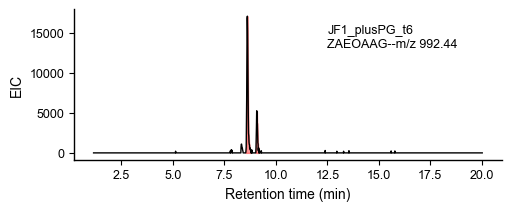

In [3]:
test_molecule = 'ZAEOAAG'
test_file = 'JF1_plusPG_t6'
_mass_to_search = 'mz_plus_1'

if 'merged_df' not in locals():
    merged_df = pd.read_pickle(f'{experiment_directory}/dataframes/All_patients_mz_spectra.pkl')
    ref_df = pd.read_pickle(f'included_small_datasets/muropeptide_reference_df.pkl').drop_duplicates()
    ref_df = ref_df.set_index('Species').drop('Mass',axis = 1)

df = merged_df[merged_df.file == test_file]
search_masses = ref_df.loc[test_molecule].values
for search_mass in search_masses:
    df[search_mass] = refine_mass(df,mass_to_search=search_mass,ppm=20)
_mass = ref_df.loc[test_molecule][_mass_to_search]

signal = df[_mass]
peaks,peak_dict = find_peaks(signal,height = 1000,width = [10,60],rel_height=1,threshold=7,prominence=1000)
left_ips,right_ips = peak_dict['left_ips'],peak_dict['right_ips']

rt_vals =[]
signal_quant = pd.DataFrame()
for peak,left_ip,right_ip in zip(peaks,left_ips,right_ips):
    mz = df.iloc[peak].mz[(df.iloc[peak].peaks > 1000) & (df.iloc[peak].mz > _mass - 1) & (df.iloc[peak].mz < _mass + 4)]
    mz_peaks = df.iloc[peak].peaks[(df.iloc[peak].peaks > 1000) & (df.iloc[peak].mz > _mass - 1) & (df.iloc[peak].mz < _mass + 4)]
    if len(mz) < 2:
        peaks = np.delete(peaks,np.where(peaks == peak))
        left_ips = np.delete(left_ips,np.where(left_ips == left_ip))
        right_ips = np.delete(right_ips,np.where(right_ips == right_ip))
    else:
        rt_vals.append(df['time'].iloc[peak])
        temp_df = pd.DataFrame({
            'signal': df[_mass].loc[left_ip:right_ip].sum(),
            'rt': df['time'].loc[peak],
            'width': df['time'].loc[right_ip] - df['time'].loc[left_ip]
        },index = [0])
        signal_quant = pd.concat([signal_quant,temp_df],axis=0)
display(signal_quant)

display(peak_dict)
fig,ax = plt.subplots(figsize=[5,2],layout = 'constrained')
ax.plot(df.time,signal,color = 'black',linewidth =1)
for left_ip,right_ip in zip(left_ips,right_ips):
    left_ip,right_ip = int(left_ip),int(right_ip)
    ax.fill_between(df.iloc[left_ip:right_ip].time,signal.iloc[left_ip:right_ip],alpha = 0.4,color ='red')
ylims = ax.get_ylim()
yscale = ylims[1] - (ylims[1] - ylims[0])/4
ax.text(12.5,yscale,f'{test_file}\n{test_molecule}--m/z {_mass:.2f}',fontsize=9)
ax.tick_params(axis='both',labelsize=9)
ax.spines[['right','top']].set_visible(False) 
ax.spines[['bottom','left']].set_linewidth(1)
ax.set_ylabel('EIC')
ax.set_xlabel('Retention time (min)')

THIS TAKES A LONG TIME TO RUN. 

This applies the test run above to all cases. 
- It merges all ms data sets into a multi-gigabyte file. The benefit is that it's more efficient to search through one file in RAM than load and search separately. 
- Searches for any matches in the reference dataframe. I only consider mz_plus_1 and mz_plus_2 values here. 
- Saves the retention times as well. Useful to verify if this is similar to previous experiments or to similar PG compounds.

The output of this is already saved in the "included_small_datasets" as a pandas dataframe (pkl file). It's called "peak_analysis.pkl." Heatmaps will use this file for plotting. 

In [5]:
if 'merged_df' not in locals():
    merged_df = pd.read_pickle(f'{experiment_directory}/dataframes/All_patients_mz_spectra.pkl')
    merged_df = merged_df[merged_df.time.between(1,15)]
    ref_df = pd.read_pickle(f'included_small_datasets/muropeptide_reference_df.pkl').drop_duplicates()
    ref_df = ref_df[~ref_df.Species.str.contains('Q|B|K')]
    ref_df = ref_df[~ref_df.Species.str.fullmatch('A|E|O|J|U|HX|AEOG-AEOG|HXAEO')]
    ref_df = ref_df.rename(columns={'mz_plus_1':'M+1', 'mz_plus_2':'M+2'})
    ref_df = ref_df.drop(['mz_plus_Na','mz_plus_3','mz_minus_1','mz_minus_2'],axis = 1)
    ref_df = pd.melt(ref_df, id_vars=['Species','Mass'], value_vars=['M+1','M+2'], var_name='Charge', value_name='mz')
    ref_df = ref_df[~((ref_df.Charge=='M+2') & (ref_df.Mass < 750))]

merged_df = merged_df[merged_df.time.between(90/60,1200/60)]
annotated_df = pd.DataFrame()
annotated_df['mz'] = ref_df.mz.unique()
annotated_df = annotated_df.sort_values(by = 'mz').reset_index().drop('index',axis=1)


annotated_df['annot'] = annotated_df.mz.apply(lambda x: annotate_masses(ref_df,x))
annotated_df['rt_mean'] = annotated_df.mz.apply(lambda x: get_retention_times(merged_df,x))
for key,df in merged_df.groupby('file'):
    annotated_df[key] = annotated_df.mz.apply(lambda x: quantify_peaks(df,x))
annotated_df.to_pickle('included_small_datasets/peak_analysis.pkl')
annotated_df.head(5)

,mz,annot,rt_mean,JF1_minPG_t6,JF1_plusPG_t0,JF1_plusPG_t6,JF3_minPG_t6,JF3_plusPG_t0,JF3_plusPG_t6,JF4_minPG_t6,...,S3_plusPG_t6,S4_minPG_t6,S4_plusPG_t0,S4_plusPG_t6,S5_minPG_t6,S5_plusPG_t0,S5_plusPG_t6,S8_minPG_t6,S8_plusPG_t0,S8_plusPG_t6
0,76.039304,[G_M+1],8.993583,1.627698e+04,9.894293e+03,1.937383e+04,22788.968231,30693.798706,26884.317566,7568.657867,...,0.000000,0.000000,41101.815613,41827.886902,15386.510315,11047.205139,15447.844757,77063.540222,71155.793396,66831.776398
1,219.097547,[AE_M+1],3.665629,3.929815e+04,0.000000e+00,3.619664e+04,0.000000,0.000000,20681.540833,0.000000,...,0.000000,0.000000,8113.833130,19248.466309,0.000000,0.000000,0.000000,8991.468842,0.000000,25045.018524
2,222.097206,[H_M+1],7.483808,5.982540e+04,3.422204e+04,5.421297e+04,0.000000,0.000000,21527.379517,0.000000,...,11773.292938,20915.578857,13563.645813,283399.891724,0.000000,0.000000,43375.103851,13220.258118,0.000000,244521.083176
3,333.176861,[AEO_M+1],2.181094,2.171208e+06,1.829303e+06,2.335216e+06,916801.080688,658684.765869,904757.239685,87172.585205,...,30800.893005,0.000000,0.000000,240513.353149,0.000000,0.000000,29575.092804,0.000000,0.000000,276788.689392
4,347.144891,[UA_M+1],8.200900,6.574358e+04,2.423419e+04,2.557142e+04,12958.902954,13782.753204,0.000000,32575.506500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


After reviewing the hits, we've sorted them by structural category as noted in the paper. This is the order below.

In [9]:
heatmap_order = [
    'XAEOAAG_M+1',
    'JAEOAAG_M+1',
    'XAEOG_M+1',
    'JAEOG_M+1',
    'JAEOAAG_M+1',
    'UAEOAAG_M+1',
    'ZAEOG_M+1',
    'ZAEOAAG_M+1',
    'Z_M+1',
    'X_M+1',
    'U_M+1',
    'HZ_M+1',
    'AEOG_M+1',
    'AEOAAG_M+1',
    'AEOAA_M+1',
    'AEOG-AEOAG_M+1',
    'AEOAAG-AEOAAG_M+2',
    'HXAEOAG-AEO_M+2',
    'AEOAG-AEOAAG_M+1',
    'AEOG-JAEOAG_M+2',
    'JAEOG-AEOAG_M+2',
    'HZAEOAAG-ZAEOG_M+2',
    'ZAEOG-XAEOAG_M+2',
    'ZAEOAG-HXAEOG_M+2',
    'UAEOG-UAEOG_M+2',
    'ZAEOAG-XAEOAAG_M+2',
    'ZAEOAG-AEOG_M+2',
    'UAEOAG-AEOG_M+2',
]


Sort the annotated dataframe by the desired order for the heatmap, then make the heatmap.

Text(38.621356944444436, 0.5, '')

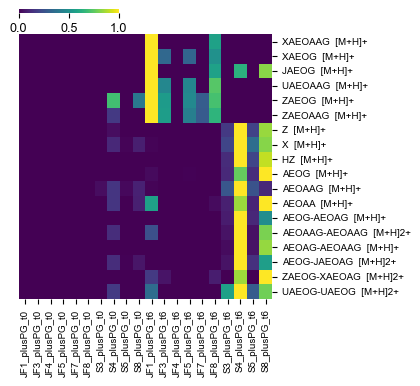

In [14]:
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True 
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False
MIN_RATIO = 3
def filter_annots(annot):
    if len(annot) == 1:
        return annot
    else:
        annot_Ms = []
annotated_df = pd.read_pickle('included_small_datasets/peak_analysis.pkl')
annotated_df['annot'] = annotated_df.annot.apply(lambda x: x[-1])
annotated_df = annotated_df[annotated_df.annot.isin(heatmap_order)]
annotated_df['hm_index'] = annotated_df.apply(lambda row: heatmap_order.index(row.annot),axis=1)
annotated_df = annotated_df.sort_values('hm_index')
annotated_df = annotated_df.drop('hm_index',axis = 1)

# Edit annotations to display the charge state, [M+H]+ or [M+H]2+.
annotated_df['charge_state'] =  annotated_df.annot.apply(lambda x: '+' if x.split('_')[1] != 'M+2' else '2+')
annotated_df['annot'] = annotated_df.apply(lambda row: row.annot.split('_')[0] + '  [M+H]' + row.charge_state,axis=1)
annotated_df = annotated_df.drop(['charge_state'],axis=1)
annotated_df = annotated_df.set_index('annot')
columns = annotated_df.columns

# remove rows that contain all 0s and those with a small signal
annotated_df = annotated_df[annotated_df.iloc[:,9:].apply(lambda row: False if row.max() < 1e4 else True,axis=1)]

# In this heatmap, we will compare t0 with t6. Only consider the PlusPG samples in this case.
temp_peaks=annotated_df[fnmatch.filter(columns,'*plusPG*t0') + fnmatch.filter(columns,'*plusPG*t6')]

#Determine the mean signal in t6 and t0. Only keep hits that are at least 2 fold greater from t0.
temp_peaks['mean_plus_PG']=annotated_df[fnmatch.filter(columns,'*plusPG*t6')].mean(axis=1)
temp_peaks['mean_min_PG']=annotated_df[fnmatch.filter(columns,'*plusPG*t0')].mean(axis=1)
temp_peaks['peak_ratio'] = temp_peaks['mean_plus_PG']/temp_peaks['mean_min_PG']
new_peaks = temp_peaks[temp_peaks['peak_ratio']>=2].copy()

temp_peaks['peak_ratio'].fillna(0)

cmap=sns.color_palette("magma", as_cmap=True)

fig,_ax = plt.subplots(figsize=[4,3.5],layout = 'constrained')
log10_dat = np.log10(new_peaks[fnmatch.filter(columns,'*plusPG*t0') + fnmatch.filter(columns,'*plusPG*t6')]+1)
dat = new_peaks[fnmatch.filter(columns,'*plusPG*t0') + fnmatch.filter(columns,'*plusPG*t6')]
dat = dat.apply(lambda row: row/row.max(),axis=1)
_cbar_ax = fig.add_axes([0.01,1.05,0.25,0.01])
_cbar_ax.tick_params(labelsize=9)
sns.heatmap(dat,cmap='viridis',ax=_ax,cbar_ax=_cbar_ax,cbar_kws={"orientation": "horizontal"})
_ax.tick_params(axis='both',labelsize=7)
_ax.set_ylabel('')

## Figure S12: Heatmap comparing minus/plus PG.

Text(37.019794444444436, 0.5, '')

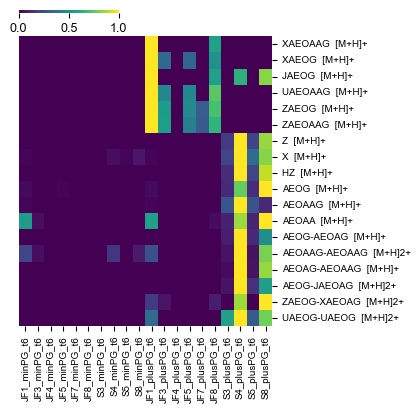

In [16]:
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True 
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False
MIN_RATIO = 3
def filter_annots(annot):
    if len(annot) == 1:
        return annot
    else:
        annot_Ms = []
annotated_df = pd.read_pickle('included_small_datasets/peak_analysis.pkl')
annotated_df['annot'] = annotated_df.annot.apply(lambda x: x[-1])
annotated_df = annotated_df[annotated_df.annot.isin(heatmap_order)]
annotated_df['hm_index'] = annotated_df.apply(lambda row: heatmap_order.index(row.annot),axis=1)
annotated_df = annotated_df.sort_values('hm_index')
annotated_df = annotated_df.drop('hm_index',axis = 1)

# Edit annotations to display the charge state, [M+H]+ or [M+H]2+.
annotated_df['charge_state'] =  annotated_df.annot.apply(lambda x: '+' if x.split('_')[1] != 'M+2' else '2+')
annotated_df['annot'] = annotated_df.apply(lambda row: row.annot.split('_')[0] + '  [M+H]' + row.charge_state,axis=1)
annotated_df = annotated_df.drop(['charge_state'],axis=1)
annotated_df = annotated_df.set_index('annot')
columns = annotated_df.columns

# remove rows that contain all 0s and those with a small signal.
annotated_df = annotated_df[annotated_df.iloc[:,8:].apply(lambda row: False if row.max() < 1e4 else True,axis=1)]

# In this heatmap, we will compare minus and plus PG samples. All were incuabted for 6 hours.
temp_peaks=annotated_df[fnmatch.filter(columns,'*minPG*') + fnmatch.filter(columns,'*plusPG*t6')]

#Determine the mean signal in minus and plus PG. Only keep hits that are at least 2 fold greater from minus PG.
temp_peaks['mean_plus_PG']=annotated_df[fnmatch.filter(columns,'*plusPG*t6')].mean(axis=1)
temp_peaks['mean_min_PG']=annotated_df[fnmatch.filter(columns,'*minPG*')].mean(axis=1)
temp_peaks['peak_ratio'] = temp_peaks['mean_plus_PG']/temp_peaks['mean_min_PG']
new_peaks = temp_peaks[temp_peaks['peak_ratio']>=2].copy()

temp_peaks['peak_ratio'].fillna(0)

cmap=sns.color_palette("magma", as_cmap=True)

fig,_ax = plt.subplots(figsize=[4,3.75],layout = 'constrained')
log10_dat = np.log10(new_peaks[fnmatch.filter(columns,'*minPG*') + fnmatch.filter(columns,'*plusPG*t6')]+1)
dat = new_peaks[fnmatch.filter(columns,'*minPG*') + fnmatch.filter(columns,'*plusPG*t6')]
dat = dat.apply(lambda row: row/row.max(),axis= 1)
_cbar_ax = fig.add_axes([0.01,1.05,0.25,0.01])
_cbar_ax.tick_params(labelsize=9)
sns.heatmap(dat,cmap='viridis',ax=_ax,cbar_ax=_cbar_ax,cbar_kws={"orientation": "horizontal"})
_ax.tick_params(axis='both',labelsize=7)
_ax.set_ylabel('')

## Figure 6C: ELISAs of lysozyme and PGLYRP2. 
Raw data is included below, copy/pasted from a Graphpad/PRISM file. 

,stat,pval,sig
Lysozyme,2.173403,0.071269,0
pglyrp2,-3.572006,0.021130,1


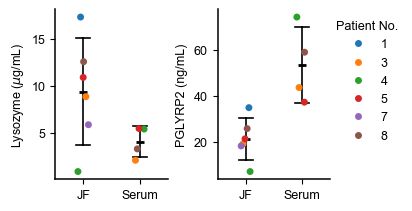

In [ ]:
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False 
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True


# Lysozome and PGLYRP2 ELISA data from LD patients. Remove NHS pooled samples and RA patients
CB_color_cycle = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 

stat_df = pd.DataFrame()
lysozyme = pd.DataFrame({
    'JF': [17.2988344606217,8.85307405830484,0.909660630255938,10.8958823354217,5.88110610998409,12.5650426725522],
    'Serum': [np.nan,2.10710388558628,5.4175411501159,5.47309887301673,np.nan,3.31337048558362],
    'patient_color': [CB_color_cycle['blue'],CB_color_cycle['orange'],CB_color_cycle['green'],CB_color_cycle['red'],CB_color_cycle['purple'],CB_color_cycle['brown']],
    'patients': [1,3,4,5,7,8]
})
lys_res = ttest_ind(lysozyme.JF,lysozyme.Serum,equal_var=False,nan_policy='omit')
stat_df = pd.concat([stat_df,pd.DataFrame({'stat':lys_res.statistic,'pval':lys_res.pvalue},index=['Lysozyme'])],axis=0)

pglyrp = pd.DataFrame({
    'JF': [34.75802132956,19.0833899784754,7.0076924127014,21.2220656329454,18.1376445316337,25.6661395844658],
    'Serum': [np.nan,43.4995762775752,74.107744968549,37.1386741098176,np.nan,58.8406427215444],
    'patient_color': [CB_color_cycle['blue'],CB_color_cycle['orange'],CB_color_cycle['green'],CB_color_cycle['red'],CB_color_cycle['purple'],CB_color_cycle['brown']],
    'patients': [1,3,4,5,7,8]
}) 
pgl_res = ttest_ind(pglyrp.JF,pglyrp.Serum,equal_var=False,nan_policy='omit')
stat_df = pd.concat([stat_df,pd.DataFrame({'stat':pgl_res.statistic,'pval':pgl_res.pvalue},index=['pglyrp2'])],axis=0)
stat_df['sig'] = stat_df.pval.apply(lambda x: 1 if x < 0.05 else 0)
display(stat_df)

fig,axs = plt.subplots(ncols=2,figsize = [4,2],layout='constrained')
lysozyme = lysozyme.melt(id_vars=['patient_color','patients'])
pglyrp = pglyrp.melt(id_vars=['patient_color','patients'])

sns.pointplot(data=lysozyme,x='variable',y='value',ax=axs[0],linestyles='',color='black',capsize=0.25,errorbar='sd',errwidth=1.2,scale=1,markers='_')
sns.pointplot(data=pglyrp,x='variable',y='value',ax=axs[1],linestyles='',color='black',capsize=0.25,errorbar='sd',errwidth=1.2,scale=1,markers='_')

sns.stripplot(data=lysozyme,x='variable',y='value',hue='patients',palette=sns.color_palette(),ax=axs[0],legend=False)
sns.stripplot(data=pglyrp,x='variable',y='value',hue='patients',palette=sns.color_palette(),ax=axs[1])
axs[1].legend(frameon=False,bbox_to_anchor=(1.7,1),title='Patient No.',fontsize=9,title_fontsize=9)
axs[0].set_ylabel('Lysozyme ($\mu$g/mL)',fontsize=9)
axs[1].set_ylabel('PGLYRP2 (ng/mL)',fontsize=9)
for ax in axs:
    ax.set_xlabel('')
    ax.tick_params(axis = 'both',labelsize=9)
    ax.spines[['right','top']].set_visible(False)
    ax.spines[['bottom','left']].set_linewidth(1.1)

## Figure 6B: Quantification of represantative sample digestion hits.

For this, we'll take example species from the heatmap
- Make EICs to define where they elute
- Sum their time windows for quantified amount. 

Text(0, 0.5, 'Joint fluid')

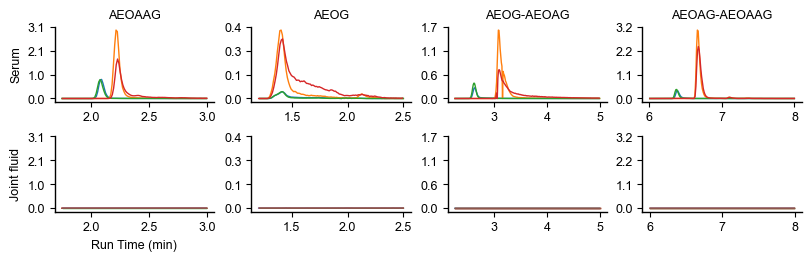

In [20]:
def y_fmt(x, y):
    return f'{(x/1e6):<2.1f}'.format(x).split('e')[0]

species_to_plot = ['AEOAAG','AEOG','AEOG-AEOAG','AEOAG-AEOAAG']

pg_detected_mass = {
    'AEOAAG': 'mz_plus_1',
    'AEOG': 'mz_plus_1',
    'AEOG-AEOAG': 'mz_plus_2',
    'AEOAG-AEOAAG': 'mz_plus_2'
}

pg_time_windows = {
    'AEOAAG': [1.75,3],
    'AEOG': [1.2,2.5],
    'AEOG-AEOAG': [2.25,5],
    'AEOAG-AEOAAG': [6,8]
}

# Pull up the reference dataframe for PG species and pull out just the ones we're interested in.
reference_df = pd.read_pickle(f'included_small_datasets/muropeptide_reference_df.pkl').drop_duplicates()
reference_df = reference_df[reference_df.Species.isin(species_to_plot)].set_index('Species')

jf_FileList = glob.glob(f'{experiment_directory}/pickle_data/*JF*plusPG*t6*')
serum_FileList = glob.glob(f'{experiment_directory}/pickle_data/S*plusPG*t6*')

fig,axs = plt.subplots(ncols = 4,nrows=2,figsize=(8,2.5),layout='constrained')
iterable_color = cycle(CB_color_cycle.items())
ylim_list = []

condition_idx = 0
for ax_row,FileList in zip(axs,[serum_FileList,jf_FileList]):
    ax_idx = 0
    for ax,_species in zip(ax_row,species_to_plot):
        time_window = pg_time_windows[_species]
        adduct = pg_detected_mass[_species]
        for file in FileList:
            filename = os.path.basename(file)
            condition = filename.split('_')[0]
            rundf = pd.read_pickle(file)
            rundf[_species] = refine_mass(rundf,mass_to_search=reference_df.loc[_species][adduct])
            temp_df = rundf[rundf.time.between(time_window[0],time_window[1])]
            ax.plot(temp_df.time,temp_df[_species],linewidth=1,label=condition)
        ylims = ax.get_ylim()
        if condition_idx == 0:
            ylim_list.append(ylims)
            ax.set_title(_species,fontsize=9)
        else:
            ylims = ylim_list[ax_idx]

        ax.set_yticks(np.linspace(0,ylims[1],4))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
        ax.tick_params(axis='both',labelsize=9)
        ax.set_ylim(ylims)
        ax.spines[['right','top']].set_visible(False) 
        ax.spines[['bottom','left']].set_linewidth(1)
        ax_idx += 1
    condition_idx += 1

axs[-1,0].set_xlabel('Run Time (min)',fontsize=9)
axs[0,0].set_ylabel('Serum',fontsize=9)
axs[1,0].set_ylabel('Joint fluid',fontsize=9)

Text(0, 0.5, 'Joint fluid')

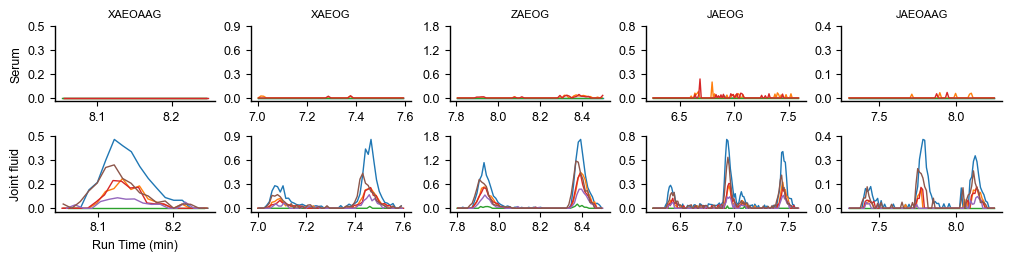

In [21]:
 
def y_fmt(x, y):
    return f'{(x/1e4):<2.1f}'.format(x).split('e')[0]

species_to_plot = ['XAEOAAG','XAEOG','ZAEOG','JAEOG','JAEOAAG']


pg_detected_mass = {
    'XAEOAAG': 'mz_plus_1',
    'XAEOG': 'mz_plus_1',
    'ZAEOG': 'mz_plus_1',
    'JAEOG': 'mz_plus_1',
    'JAEOAAG': 'mz_plus_1'
}

pg_time_windows = {
    'XAEOAAG': [8.05,8.25],
    'XAEOG': [7,7.6],
    'ZAEOG': [7.8,8.5],
    'JAEOG': [6.25,7.6],
    'JAEOAAG': [7.3,8.25]
}
# Pull up the reference dataframe for PG species and pull out just the ones we're interested in.
reference_df = pd.read_pickle(f'included_small_datasets/muropeptide_reference_df.pkl').drop_duplicates()
reference_df = reference_df[reference_df.Species.isin(species_to_plot)].set_index('Species')


jf_FileList = glob.glob(f'{experiment_directory}/pickle_data/*JF*plusPG*t6*')
serum_FileList = glob.glob(f'{experiment_directory}/pickle_data/S*plusPG*t6*')

fig,axs = plt.subplots(nrows = 2,ncols=len(species_to_plot),figsize=(10,2.5),layout='constrained')
iterable_color = cycle(CB_color_cycle.items())
ylim_list = []

condition_idx = 0
for ax_row,FileList in zip(axs[::-1],[jf_FileList,serum_FileList]):
    ax_idx = 0
    for ax,_species in zip(ax_row,species_to_plot):
        time_window = pg_time_windows[_species]
        adduct = pg_detected_mass[_species]
        for file in FileList:
            filename = os.path.basename(file)
            condition = filename.split('_')[0]
            rundf = pd.read_pickle(file)
            rundf[_species] = refine_mass(rundf,mass_to_search=reference_df.loc[_species][adduct])
            temp_df = rundf[rundf.time.between(time_window[0],time_window[1])]
            ax.plot(temp_df.time,temp_df[_species],linewidth=1,label=condition)
        ylims = ax.get_ylim()
        if condition_idx == 0:
            ylim_list.append(ylims)
        else:
            ylims = ylim_list[ax_idx]
            ax.set_title(_species,fontsize=8)

        ax.set_yticks(np.linspace(0,ylims[1],4))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
        ax.tick_params(axis='both',labelsize=9)
        ax.set_ylim(ylims)
        ax.spines[['right','top']].set_visible(False) 
        ax.spines[['bottom','left']].set_linewidth(1)
        ax_idx += 1
    condition_idx += 1

axs[-1,0].set_xlabel('Run Time (min)',fontsize=9)
axs[0,0].set_ylabel('Serum',fontsize=9)
axs[1,0].set_ylabel('Joint fluid',fontsize=9)


,fluid,patient,AEOAAG,AEOG,AEOG-AEOAG,AEOAG-AEOAAG,XAEOAAG,XAEOG,JAEOG,JAEOAAG,patient_color
0,JF,1,6.251839e+03,6.976622e+03,2.976000e+02,2.001251e+03,25433.980957,67549.202591,112750.293991,49415.299957,#377eb8
1,JF,3,6.556807e+02,5.931019e+03,0.000000e+00,4.670330e+02,8657.661713,22998.672394,34285.537750,11388.240707,#ff7f00
2,JF,4,0.000000e+00,2.400491e+03,0.000000e+00,0.000000e+00,0.000000,230.851852,455.088196,0.000000,#4daf4a
3,JF,5,8.225939e+02,5.979984e+03,0.000000e+00,0.000000e+00,8277.438477,20833.045029,32541.646454,12168.139099,#f781bf
4,JF,7,2.370194e+02,2.402871e+03,0.000000e+00,2.420105e+02,4296.437057,11448.769165,18336.081787,4658.733871,#a65628
5,JF,8,6.994164e+02,6.099519e+03,0.000000e+00,0.000000e+00,15382.389984,35429.281418,65753.810547,29149.195984,#984ea3
6,S,3,4.430714e+06,5.626373e+05,2.271035e+06,2.124784e+06,0.000000,0.000000,209.586960,0.000000,#ff7f00
7,S,4,1.659007e+07,4.367569e+06,1.683209e+07,1.704192e+07,0.000000,686.250580,9909.136856,1240.612228,#4daf4a
8,S,5,4.260885e+06,4.484979e+05,2.703733e+06,2.287615e+06,0.000000,0.000000,0.000000,0.000000,#f781bf
9,S,8,1.319110e+07,6.728465e+06,1.448087e+07,1.542055e+07,0.000000,497.062256,8332.714371,547.298508,#984ea3


Statistics comparing JF to serum.


,mass,stat,pval,sig
AEOAAG,532.272550,0.0,0.009524,1
AEOG,390.198324,0.0,0.009524,1
AEOG-AEOAG,832.415920,0.0,0.008911,1
AEOAG-AEOAAG,974.490147,0.0,0.013062,1
XAEOAAG,1010.452425,22.0,0.030728,1
XAEOG,868.378199,22.0,0.042197,1
JAEOG,665.298826,22.0,0.038095,1
JAEOAAG,807.373053,21.0,0.066568,0


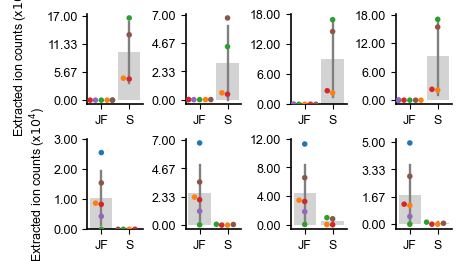

In [18]:
species_to_plot = ['AEOAAG','AEOG','AEOG-AEOAG','AEOAG-AEOAAG','XAEOAAG','XAEOG','JAEOG','JAEOAAG']

reference_df = pd.read_pickle(f'included_small_datasets/muropeptide_reference_df.pkl').drop_duplicates()
reference_df = reference_df[reference_df.Species.isin(species_to_plot)].set_index('Species')

patient_colors = {
    1: '#377eb8',
    3: '#ff7f00',
    4: '#4daf4a',
    5: '#f781bf',
    7: '#a65628',
    8: '#984ea3'
}

def y_fmt(x, y):
    return f'{(x/1e6):<2.2f}'.format(x).split('e')[0]
to_round = 1e6

pg_detected_mass = {
    'AEOAAG': 'mz_plus_1',
    'AEOG': 'mz_plus_1',
    'AEOG-AEOAG': 'mz_plus_2',
    'AEOAG-AEOAAG': 'mz_plus_2',
    'XAEOAAG': 'mz_plus_1',
    'XAEOG': 'mz_plus_1',
    'ZAEOG': 'mz_plus_1',
    'JAEOG': 'mz_plus_1',
    'JAEOAAG': 'mz_plus_1'
}

pg_time_windows = {
    'AEOAAG': [1.75,3],
    'AEOG': [1.2,2.5],
    'AEOG-AEOAG': [2.25,5],
    'AEOAG-AEOAAG': [6,8],
    'XAEOAAG': [8.05,8.25],
    'XAEOG': [7,7.6],
    'ZAEOG': [7.8,8.5],
    'JAEOG': [6.25,7.6],
    'JAEOAAG': [7.3,8.25]
}

merged_df = pd.read_pickle(f'{experiment_directory}/dataframes/All_patients_mz_spectra.pkl')
merged_df = merged_df[(merged_df.inc_time == 6) & (merged_df.pg_state == 'plus')]
for _species in species_to_plot:
    adduct = pg_detected_mass[_species]
    merged_df[_species] = refine_mass(merged_df,mass_to_search=reference_df.loc[_species][adduct])

df = pd.DataFrame()

for _species in species_to_plot:
    time_window = pg_time_windows[_species]
    temp_df = merged_df[merged_df.time.between(time_window[0],time_window[1])].groupby(['fluid','patient']).sum(numeric_only=True)
    df = pd.concat([df,temp_df[_species]],axis=1)
df = df.reset_index(names=['fluid','patient'])
df['patient_color'] = df.patient.apply(lambda x: patient_colors[x])
display(df)

fig,axs = plt.subplots(nrows=2,ncols=4,layout='constrained',figsize = [4.5,2.5])

for _species,_ax in zip(species_to_plot,axs.ravel()):
    sns.barplot(data=df,x='fluid',y=_species,color = 'lightgray',errcolor='gray',ax=_ax,errwidth=1.7,errorbar='sd')
    sns.swarmplot(data=df,x='fluid',y=_species,hue='patient_color',ax=_ax,size=4,legend=False)

    if _species == 'XAEOAAG':
        def y_fmt(x, y):
            return f'{(x/1e4):<2.2f}'.format(x).split('e')[0]
        to_round = 1e4
    _ax.spines[['left','bottom']].set_linewidth(1.2)
    _ax.spines[['right','top']].set_visible(False)
    _ax.tick_params(axis='both',labelsize=9)
    _ax.set_xlabel('')
    _ax.set_ylabel('')

    ylims = _ax.get_ylim()
    _ax.set_yticks(np.linspace(0,round(ylims[1]/to_round,0)*to_round,4))
    _ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))

axs[0,0].set_ylabel('Extracted ion counts (x$10^6$)',fontsize=9,labelpad=12)
axs[1,0].set_ylabel('Extracted ion counts (x$10^4$)',fontsize=9)

jf_df = df[df.fluid == 'JF']
s_df = df[df.fluid == 'S']
stat_df = pd.DataFrame()
for _species in species_to_plot:
    res = mannwhitneyu(jf_df[_species],s_df[_species])
    temp_df = pd.DataFrame({
        'mass': reference_df.loc[_species][adduct],
        'stat': res.statistic,
        'pval': res.pvalue
        },index=[_species])
    stat_df = pd.concat([stat_df,temp_df],axis=0)

stat_df['sig'] = stat_df.pval.apply(lambda x: 1 if x < 0.05 else 0)
print('Statistics comparing JF to serum.')
display(stat_df)